In [51]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import os
import pickle

In [52]:
def lorentzian_components(params_gr, t):

    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')
    # freq  = np.linspace(1.0/Ttot, 1./2/dt, len(t)) # Hz

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    
    #VPSD /= 1e6     # units of VPSD is (m/s)**2/Hz
    VPSD *= (freq[-1] - freq[0])
           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    #print(len(phase), len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_regular_data_H0(params_gr, params_act, t):
    
    '''
    Inputs:
    - params_gr:= 
            see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - t = time (days)
        - y = RV (m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ygr = lorentzian_components(params_gr, t*3600*24)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    amp, gam, logP, met  = params_act
    k  = kernels.ExpSine2Kernel(gamma=gam, log_period=logP)
    k *= kernels.ExpSquaredKernel(metric=met) # metric correspondind to r^2/lambda  is 1
    k *= amp**2 
    # print(k.get_parameter_vector())
    
    gp = george.GP(k)

    # generate synthetic dataset
    yact = gp.sample(t)
    
    # =========================================================================
    # Generate the intrincsic errors
    eb = np.random.normal(loc = 3, scale= 0.30, size=len(t))
    if (any(eb < 0)) : eb = np.where(eb<0, 1.5, eb)
    yerr = np.random.normal(loc=0, scale=eb, size=len(t)) # this has to be defined according to the paper
    #print('std(yerr) = %f m/s'%np.std(yerr))

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors 
    ytot = ygr + yact + yerr * np.random.randn(len(t))
    
    return ygr,yact, yerr* np.random.randn(len(t)), eb
    #return ytot, yerr



# Test 1

<IPython.core.display.Javascript object>


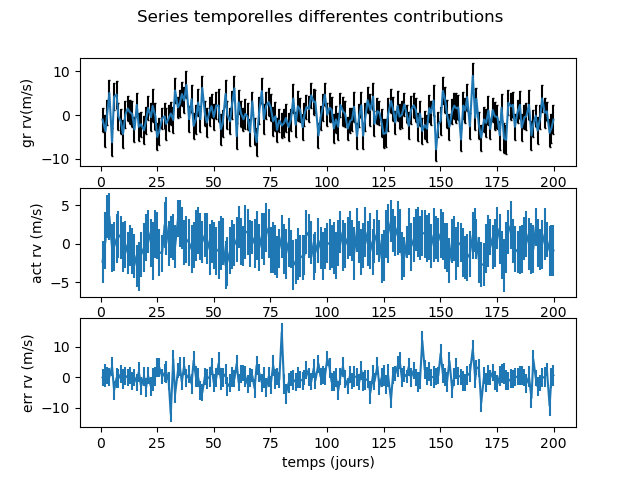

<IPython.core.display.Javascript object>


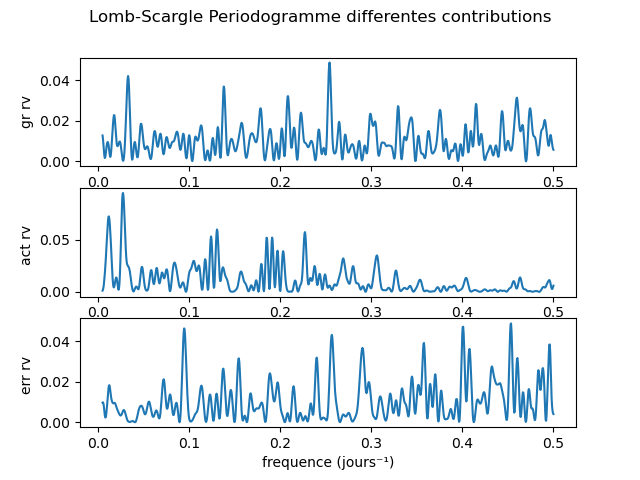

<IPython.core.display.Javascript object>


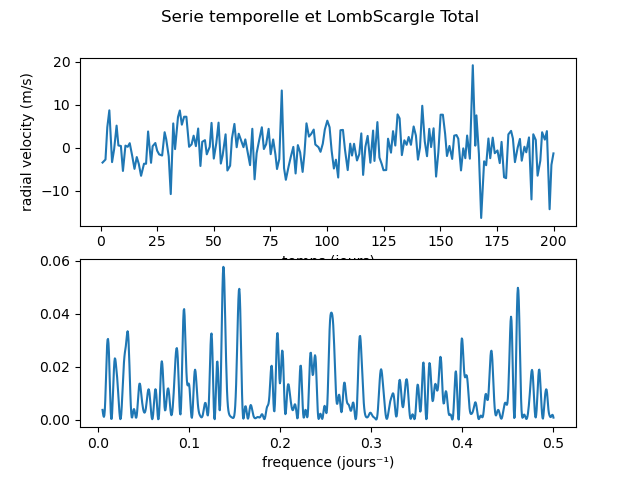

(<Axes: xlabel='frequence (jours⁻¹)'>,
 Text(0.5, 0, 'frequence (jours⁻¹)'))

In [53]:
#Generate time and frequency
#Over-sampling
Ttot = 200 # days
facteur_surech = 10
N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
t_over = np.linspace(0,Ttot,N) #days

# Irregular sampling 1 : with normal distribution
facteur_ech = 10
t = np.zeros(Ttot)

ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[0] = t_over[ ind0 ] 

ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[-1]  = t_over[ ind_fin ]

pas = N/Ttot
for i in range(Ttot-1):
    ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
    t[i] = t_over[ ind ]


#Simu
A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz

params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]

Prot = random.randint(8,80)#62# days -- Prot to be chosen randomly in HARPS sample (see paper)

amp  = gamma.rvs(2.0, 0.5) 
epsilon = uniform.rvs(0.5, 1)
tau = np.random.normal(3*Prot, 0.1*Prot) 
gam  = 2.0/epsilon #not change
logP = np.log(Prot) #not change 
met  = 1.0 # not change 

params_act = [amp, gam, logP, met]
    
ygr, yact, yerr,eb = generate_regular_data_H0(params_gr, params_act, t)
y = ygr + yact + yerr

dt = np.median(np.diff(t))
fmin = 1/(t[-1]-t[0])
fmax = (1/dt)/2 
freq = np.linspace(fmin,fmax,990)

lsgr = LombScargle(t,ygr,eb).power(freq, method = 'cython')
lsact = LombScargle(t,yact,eb).power(freq, method = 'cython')
lserr = LombScargle(t,yerr,eb).power(freq, method = 'cython')
ls = LombScargle(t,y,eb).power(freq, method= 'cython')

plt.figure()
plt.suptitle("Series temporelles differentes contributions")
plt.subplot(311), plt.errorbar(t,ygr,yerr=eb,ecolor='black',capsize=1), plt.xlabel("temps (jours)"), plt.ylabel("gr rv(m/s)")
plt.subplot(312), plt.errorbar(t,yact,yerr=eb), plt.xlabel("temps (jours)"), plt.ylabel("act rv (m/s)")
plt.subplot(313), plt.errorbar(t,yerr,yerr=eb), plt.xlabel("temps (jours)"), plt.ylabel("err rv (m/s)")

plt.figure()
plt.suptitle("Lomb-Scargle Periodogramme differentes contributions")
plt.subplot(311), plt.plot(freq, lsgr), plt.xlabel("frequence (jours⁻¹)"), plt.ylabel("gr rv")
plt.subplot(312), plt.plot(freq, lsact), plt.xlabel("frequence (jours⁻¹)"), plt.ylabel("act rv ")
plt.subplot(313), plt.plot(freq, lserr), plt.xlabel("frequence (jours⁻¹)"),plt.ylabel("err rv ")

plt.figure()
plt.suptitle("Serie temporelle et LombScargle Total")
plt.subplot(211), plt.plot(t,y), plt.xlabel("temps (jours)"), plt.ylabel("radial velocity (m/s)")
plt.subplot(212), plt.plot(freq, ls), plt.xlabel("frequence (jours⁻¹)")

<IPython.core.display.Javascript object>


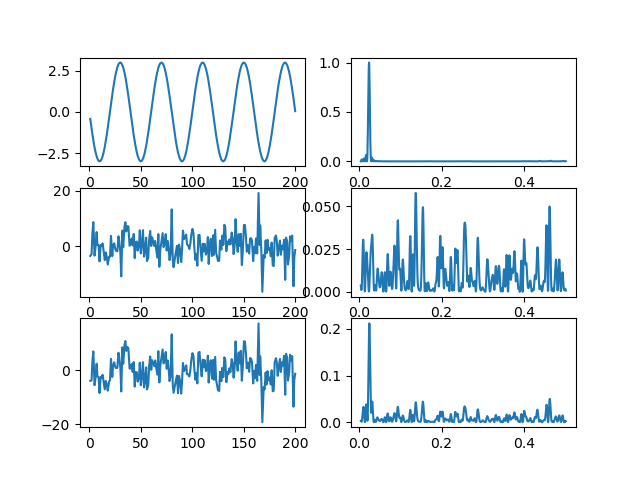

(<Axes: >, [<matplotlib.lines.Line2D at 0x7f2552f39e10>])

In [54]:
def generate_planete(params_pl,t):
    """
    - params_pl
            - Ppl (Orbital period)
            - K (semi-amplitude)
            - T0 ( Phase à l'origine)
    """
    Ppl, K, T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)

Ppl = 40
K = 3
T0 = 20
params_pl = Ppl, K, T0

ypl = generate_planete(params_pl, t)
ytot = y+ypl

lspl = LombScargle(t,ypl).power(freq,method='cython')
lstot = LombScargle(t,ytot,eb).power(freq,method='cython')

plt.figure()

plt.subplot(321), plt.plot(t,ypl)
plt.subplot(323), plt.plot(t,y)
plt.subplot(325), plt.plot(t,ytot)

plt.subplot(322), plt.plot(freq, lspl)
plt.subplot(324), plt.plot(freq, ls)
plt.subplot(326), plt.plot(freq,lstot)
